Код кластеризации

In [14]:
# def axis_bounds(embedding):
#     left, right = embedding.T[0].min(), embedding.T[0].max()
#     bottom, top = embedding.T[1].min(), embedding.T[1].max()
#     adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
#     return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

In [15]:
# import numpy as np
# import sklearn.datasets
# import umap
# import umap.utils as utils
# import umap.aligned_umap
# import matplotlib.pyplot as plt

# # print(embeddings.shape)
# # constant_dict = {i:i for i in range(312)}
# # constant_relations = [constant_dict for i in range(9)]
# # # print(len(constant_relations), )
# # # embeddings_reshape = embeddings.reshape(1, 377, 312)
# # # print(np.array([embeddings for i in range(5)]).shape)
# # neighbors_mapper = umap.AlignedUMAP(
# #     n_neighbors=[3,4,5,7,11,16,22,29,37,45,54],
# #     min_dist=[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45],
# #     alignment_window_size=2,
# #     alignment_regularisation=1e-3,
# # ).fit(
# #     [embeddings for i in range(10)], relations=constant_relations
# # )


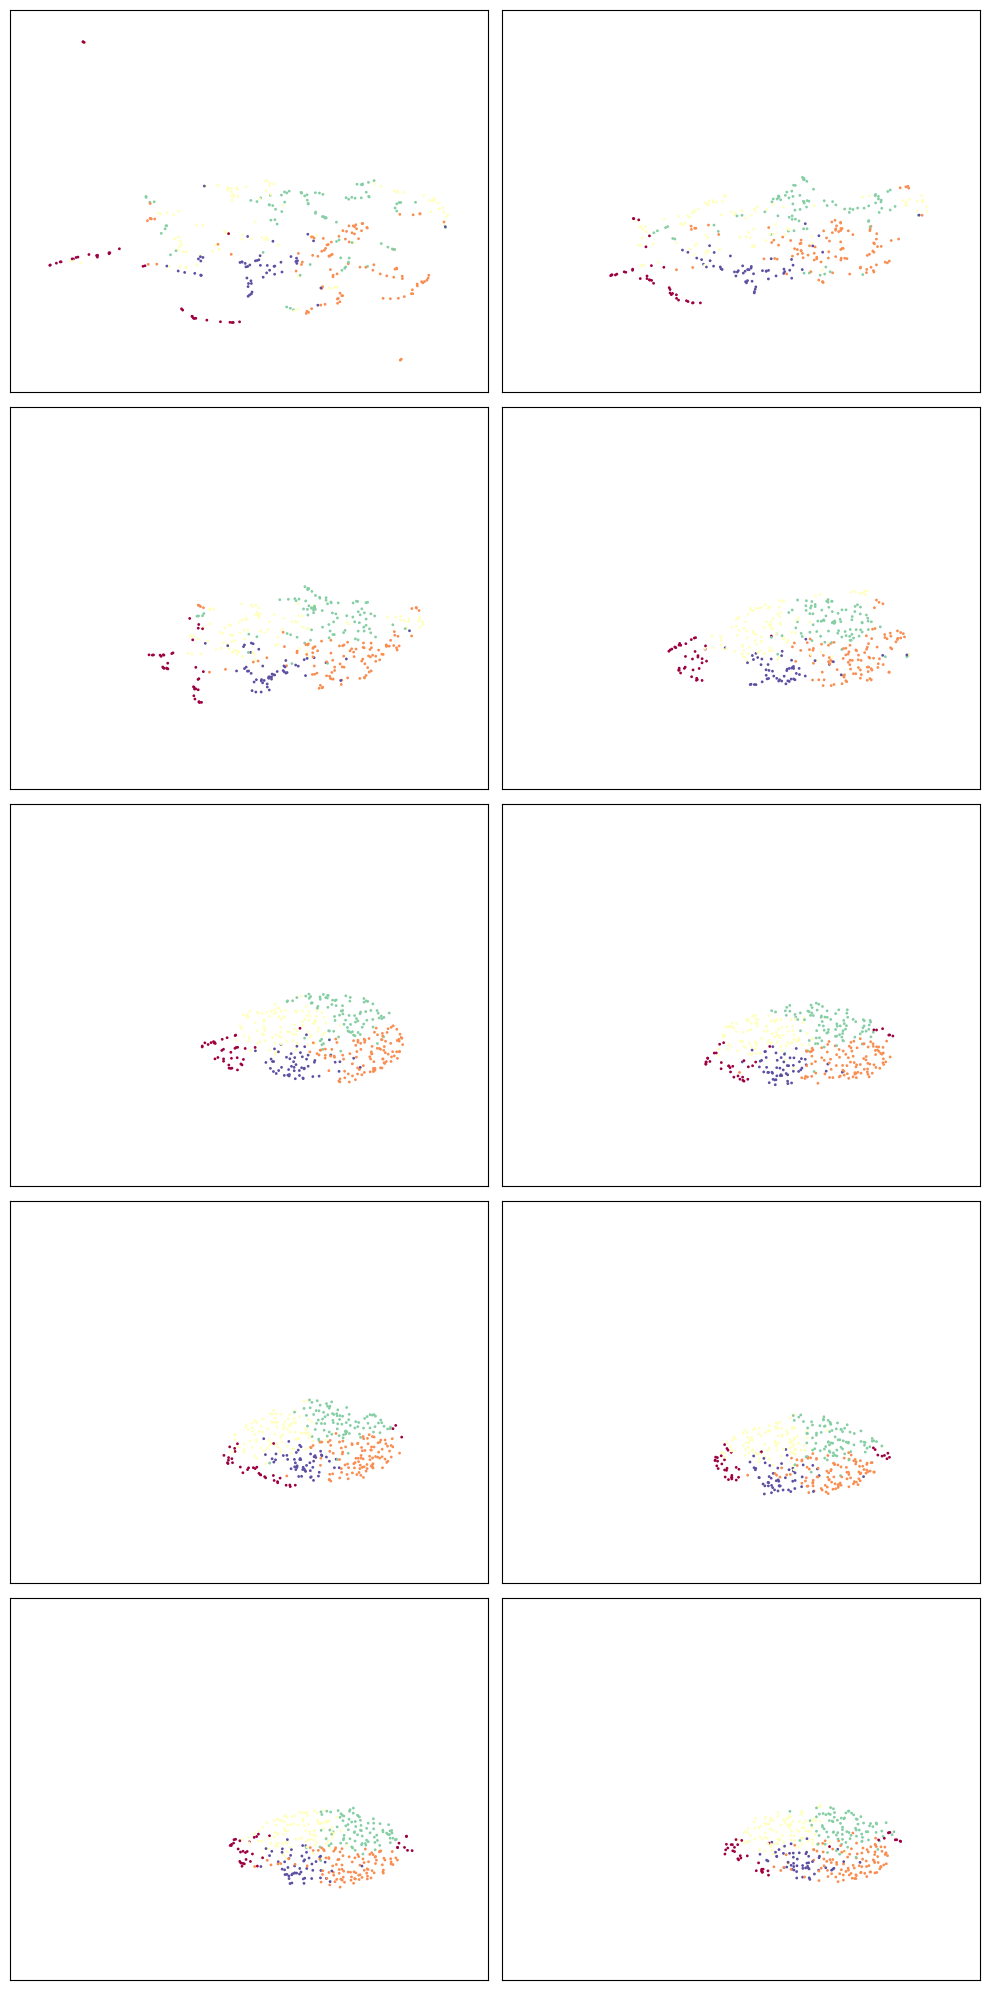

In [ ]:
# fig, axs = plt.subplots(5,2, figsize=(10, 20))
# ax_bound = axis_bounds(np.vstack(neighbors_mapper.embeddings_))
# for i, ax in enumerate(axs.flatten()):
#     ax.scatter(*neighbors_mapper.embeddings_[i].T, s=1, c=labels, cmap="Spectral")
#     ax.axis(ax_bound)
#     ax.set(xticks=[], yticks=[])
# plt.tight_layout()

In [24]:
# from collections import defaultdict
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from collections import defaultdict
# import numpy as np

# def extract_keywords_by_cluster(documents, labels, top_n=3):
#     # Group documents by cluster labels
#     clustered_documents = defaultdict(list)
#     for doc, label in zip(documents, labels):
#         clustered_documents[label].append(doc)

#     # Initialize the TfidfVectorizer
#     tfidf_vectorizer = TfidfVectorizer()

#     # Dictionary to store keywords for each cluster
#     cluster_keywords = {}

#     for cluster, docs in clustered_documents.items():
#         # Fit TF-IDF model for the current cluster
#         if docs:  # Check if there are documents in the cluster
#             tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
#             feature_names = tfidf_vectorizer.get_feature_names_out()

#             # Sum TF-IDF for each word (column)
#             summed_tfidf = np.sum(tfidf_matrix, axis=0).A1

#             # Get indices of top N TF-IDF values
#             top_indices = np.argsort(summed_tfidf)[::-1][:top_n]

#             # Form the list of top N keywords for the current cluster
#             keywords = [(feature_names[index], summed_tfidf[index]) for index in top_indices]
#             cluster_keywords[cluster] = keywords

#     return cluster_keywords

# lls = extract_keywords_by_cluster(qs, labels)
# lls

In [ ]:
%pip install transformers umap-learn pymorphy2 razdel

In [7]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import nltk
import razdel
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import pandas as pd
import plotly.express as px
import torch
import seaborn as sns
import datetime
from collections import Counter
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import DBSCAN, KMeans, Birch, AgglomerativeClustering
from tqdm import tqdm
%matplotlib inline

def remove_urls(documents) -> list:
    return [re.sub('https?:\/\/.*?[\s+]', '', text) for text in documents]

def replace_newline(documents):
    documents = [text.replace('\n', ' ') + ' ' for text in documents]
    return documents

def remove_strange_symbols(documents):
    return [re.sub(f'[^A-Za-zА-Яа-яё0-9{string.punctuation}\ ]+', ' ', text) for text in documents]

def tokenize(documents) -> list:
    return [[token.text for token in razdel.tokenize(text)] for text in documents]

def to_lower(documents) -> list:
    return [text.lower() for text in documents]

def remove_punctuation(tokenized_documents):
    ttt = set(string.punctuation)
    return [[token for token in tokenized_text if not set(token) < ttt] for tokenized_text in tokenized_documents]

def remove_numbers(documents):
    return [re.sub('(?!:\s)\d\.?\d*', ' ', text) for text in documents]

def remove_stop_words(tokenized_documents, stop_words) -> list:
    return [[token for token in tokenized_text if token not in stop_words] for tokenized_text in
            tokenized_documents]
# def lemmatize(documents) -> list:
#   return [''.join(lemmatizer.lemmatize(text)) for text in documents]
def lemmatize_text(text, morph):
    words = text
    # print('[eq]',words)
    lemmatized_words = [[morph.parse(i)[0].normal_form for i in word.split()] for word in words]
    # print(lemmatized_words)
    return [' '.join(lst) for lst in lemmatized_words]



def preprocessing(documents, morph, stop_words):
        documents = replace_newline(documents)
        documents = remove_urls(documents)
        documents = remove_strange_symbols(documents)
        documents = to_lower(documents)
        documents = lemmatize_text(documents, morph)
        documents = remove_numbers(documents)
        tokenized_documents = tokenize(documents)
        # print(tokenized_documents)
        tokenized_documents = remove_stop_words(tokenized_documents, stop_words)
        # print(tokenized_documents)
        tokenized_documents = remove_punctuation(tokenized_documents)
        documents = [' '.join(tokenized_text) for tokenized_text in tokenized_documents]
        # print(documents)
        return documents

def umap_data(data, n):
    reducer = umap.UMAP(n_components=n)
    scaled_data = StandardScaler().fit_transform(data)
    embeddings = reducer.fit_transform(scaled_data)
    return embeddings




def get_clusterisation(path, num_clusters):

  dd = pd.read_csv(f'{path}')
  qs = list(dd['question_2']) + list(dd['question_3']) + list(dd['question_4']) + list(dd['question_5'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  nltk.download('punkt')
  nltk.download('stopwords')

  morph = MorphAnalyzer()
  stop_words = stopwords.words('russian')
  qs = preprocessing(qs, morph, stop_words)

  tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")
  model = AutoModel.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")

  model.to(device)

  qs = list(set(qs))
  embeddings = []

  for qs1 in tqdm(qs):

      encoded_input = tokenizer(qs1, padding=False, return_tensors='pt').to(device)

      with torch.no_grad():
          model_output = model(**encoded_input)

      embeddings.append(model_output.last_hidden_state.mean(dim=1))

  embeddings = torch.stack(embeddings).cpu().numpy().squeeze(1)

  # pca = PCA(n_components=2)

  # reduced_embeddings = pca.fit_transform(embeddings)


  # tsne = TSNE(n_components=2, n_iter = 2000)
  # X_tsne = tsne.fit_transform(embeddings)

  embeds_reduced8 = umap_data(embeddings, 8)
  embeds_reduced2 = umap_data(embeddings, 2)

  kmeans = KMeans(n_clusters=num_clusters, random_state=42,tol = 1e-2)
  kmeans.fit(embeds_reduced8)
  # clusters_birch = Birch(n_clusters=None).fit(embeddings)

  # clusters = DBSCAN(n_jobs=-1, min_samples=4, eps = 0.5).fit(embeds_reduced8)

  labels = kmeans.labels_
  # print(labels)
  fig = px.scatter(x=embeds_reduced2[:, 0], y=embeds_reduced2[:, 1], color=labels)
  return fig
fig = get_clusterisation('/content/train_data.csv', 5)
fig.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 377/377 [00:03<00:00, 94.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

